# Access GEDI L4B Dataset with OGC Web Services

This tutorial will demonstrate how to visualize and access [Global Ecosystem Dynamics Investigation (GEDI) L4B Gridded Aboveground Biomass Density (AGBD) dataset](https://doi.org/10.3334/ORNLDAAC/2017) using the [Open Geospatial Consortium (OGC)](http://www.opengeospatial.org/) web services. The OGC web services offer a simple HTTP interface for requesting access, visualization, and processing of geospatial datasets. GEDI L4B dataset is available in ORNL DAAC's [Spatial Data Access Tools (SDAT)](https://webmap.ornl.gov/ogc/dataset.jsp?ds_id=2017), which offers OGC-based web services to visualize and download spatial data in various user-selected spatial/temporal extents and formats. For GEDI L4B, which is a gridded dataset, two different requests are currently supported: (1) [web map service (WMS)](https://www.ogc.org/standards/wms/introduction) to request map images for visualization of geospatial data from a remote server, (2) [web coverage service (WCS)](https://www.ogc.org/standards/wcs) to download geospatial data from a remote server.

For this tutorial, we will first visualize the GEDI L4B dataset over Australia using the OGC WMS service and then access the dataset using the OGC WCS service to compute summaries of AGBD for six states and two territories of Australia.

In [1]:
# import python modules
import folium
import owslib.wcs as wcs
import owslib.wms as wms
import pandas as pd
import geopandas as gpd
import requests as re
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import FloatImage
from rasterstats import zonal_stats
from rasterio.plot import show

Let's read and plot the GeoJSON file with the states and territories of Australia.

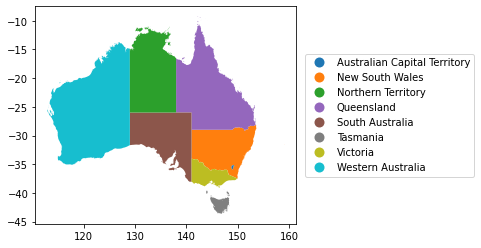

In [2]:
aus = gpd.read_file("polygons/australia.json") 
ax = aus.plot(column="STE_NAME", legend=True, legend_kwds={'bbox_to_anchor':(1.7, .5), 'loc': 'right'})

## Visualizing with Web Map Service (WMS)
We will first retrieve the ORNL DAAC's WMS capabilities document. The WMS capabilities document allows access to service-level metadata, operations and output formats supported, and the list of available layers. Let's connect to ORNL DAAC's WMS service and print the number of available WMS layers.

In [3]:
ornl_wms_url = "https://webmap.ornl.gov/ogcbroker/wms"
ornl_wms = wms.WebMapService(ornl_wms_url)
print(f'{ornl_wms.identification.title} currently provides {len(ornl_wms.contents)} WMS layers.')

ORNL DAAC WMS Server currently provides 21501 WMS layers.


We will now print the available capabilities of the ORNL DAAC WMS Server. 

In [4]:
for i, op in enumerate(ornl_wms.operations):
    print(f'{i+1}. {op.name}')

1. GetCapabilities
2. GetMap
3. GetFeatureInfo
4. DescribeLayer
5. GetLegendGraphic
6. GetStyles


We will later use the `GetMap` capability to request the map of GEDI L4B layers. Let's print the formats supported by the `GetMap` request. 

In [5]:
for i, fmt in enumerate(ornl_wms.getOperationByName('GetMap').formatOptions):
    print(f'{i+1}. {fmt}')

1. image/png
2. image/gif
3. application/x-pdf
4. image/jpeg
5. image/png; mode=8bit
6. image/svg+xml
7. image/tiff
8. application/vnd.google-earth.kml+xml
9. application/vnd.google-earth.kmz


The `GetMap` request has the above nine supported formats available. We will use the `image/png` format to get the GEDI L4B map image.

The GEDI L4B has a dataset id of `2017`, which is the suffix component of the GEDI L4B dataset DOI (`doi.org/10.3334/ORNLDAAC/2017`). We can use the dataset ID to print out available WMS layer names for the dataset. Refer to the [L4B user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html) for a description of these layers. The GEDI L4B has ten layers available.

In [6]:
l4b_dsid = '2017' # dataset id
p = [[i, ornl_wms[i].title] for i in ornl_wms.contents.keys() if i.startswith(l4b_dsid)]
l4b_layers = pd.DataFrame(sorted(p), columns=["wms_layer_id","wms_layer_title"])
l4b_layers = l4b_layers.set_index(['wms_layer_id'])
pd.set_option('display.max_colwidth', None) # this is needed to print full layer title
l4b_layers

,wms_layer_title
wms_layer_id,
2017_1,"GEDI L4B Gridded Mean Aboveground Biomass Density (AGBD), Version 2, Mission Weeks 19-138"
2017_10,"GEDI L4B Gridded Mode of Inference, Version 2, Mission Weeks 19-138"
2017_2,"GEDI L4B Gridded AGBD Standard Error, Version 2, Mission Weeks 19-138"
2017_3,"GEDI L4B Gridded Percentage Standard Error, Version 2, Mission Weeks 19-138"
2017_4,"GEDI L4B Gridded AGBD Quality Flag, Version 2, Mission Weeks 19-138"
2017_5,"GEDI L4B Gridded Variance Component 1, Version 2, Mission Weeks 19-138"
2017_6,"GEDI L4B Gridded Variance Component 2, Version 2, Mission Weeks 19-138"
2017_7,"GEDI L4B Gridded Number of Clusters, Version 2, Mission Weeks 19-138"
2017_8,"GEDI L4B Gridded Number of Samples, Version 2, Mission Weeks 19-138"


We will use the Python module [Folium](https://python-visualization.github.io/folium/), which we imported earlier, for interactive visualization of the GEDI L4B Gridded Mean AGBD layer, which has a `wms_layer_id` of `2017_1` in the table above.

In [7]:
m = folium.Map()

# setting zoom to Australia boundary
b = aus.total_bounds 
bbox = [[b[1], b[0]], [b[3], b[2]]]
m.fit_bounds(bbox)

# adding australia states
folium.GeoJson(aus, name="Australia States", 
               tooltip=folium.features.GeoJsonTooltip(fields=['STE_NAME'], aliases=['State:'])
              ).add_to(m)

for layer_id in l4b_layers.index:
    # adding GEDI L4B Mean AGBD layer (2017_1)
    if (layer_id == '2017_1'):
        # creating wms layer
        folium.raster_layers.WmsTileLayer(name=l4b_layers.loc[layer_id]['wms_layer_title'],
                                          bounds=bbox, url=ornl_wms_url, fmt="image/png", 
                                          transparent=True, layers=layer_id).add_to(m)
        
        # adding map legend
        legend_f = 'legend.png'
        with open(legend_f, 'wb') as f:
        #     legend_url = ornl_wms[layer_id].styles['default']['legend']
            legend_url = (f"{ornl_wms_url}?version=1.1.1&service=WMS&request=GetLegendGraphic"
                          f"&layer={layer_id}&format=image/png&STYLE=default")
            f.write(re.get(legend_url).content)
        FloatImage(legend_f, bottom=0, left=0).add_to(m)

# adding layer control
folium.LayerControl().add_to(m)

# display the map
m

We can see in the above map how AGBD are distributed more along the north and eastern regions dominated by forests and woodlands than in the west and central areas dominated by semi-arid shrublands and grasslands. If we zoom in further on the above map, we will notice gaps in the GEDI coverage, filled with NoData values. The current GEDI L4B dataset covers a period of 2019-04-18 to 2021-08-04 (GEDI mission weeks 19-138). As GEDI collects more and more shots, there will be fewer gaps in the data coverage.

## Access data with Web Coverage Service (WCS)
Let's retrieve the ORNL's WCS capabilities document. The capabilities document provides operations and services offered by the WCS Server. We will first retrieve the data for the Australia bounding box and then compute summaries for the states and territories.

In [8]:
ornl_wcs_url = "https://webmap.ornl.gov/ogcbroker/wcs"
ornl_wcs = wcs.WebCoverageService(ornl_wcs_url)
print(f'{ornl_wcs.identification.title} currently provides {len(ornl_wcs.contents)} WCS layers.')

ORNL DAAC WCS Server currently provides 20773 WCS layers.


The ORNL DAAC WCS Server has the following three capabilities. 

In [9]:
for i, op in enumerate(ornl_wcs.operations):
    print(f'{i+1}. {op.name}')

1. GetCapabilities
2. DescribeCoverage
3. GetCoverage


`DescribeCoverage` provides information about the layers' spatial extent, CRS, metadata, and formats. `GetCoverage` retrieves the actual spatial data or its subset based on spatio-temporal parameters. We will use `GetCoverage` capability to request GEDI L4B layers.

Now, let's print information about the GEDI L4B mean AGBD WCS layer (`2017_1`).

In [10]:
layer_wcs = ornl_wcs['2017_1']
wcs_meta = f'''Layer title : {layer_wcs.title}
Supported CRS : {layer_wcs.supportedCRS}
Bounding Box : {layer_wcs.boundingboxes}
Formats : {layer_wcs.supportedFormats}
Grid upper limits : {layer_wcs.grid.highlimits}'''
print(wcs_meta)

Layer title : GEDI L4B Gridded Mean Aboveground Biomass Density (AGBD), Version 2, Mission Weeks 19-138
Supported CRS : [urn:ogc:def:crs:EPSG::6933, urn:ogc:def:crs:EPSG::4326, urn:ogc:def:crs:EPSG::3785, urn:ogc:def:crs:EPSG::54004, urn:ogc:def:crs:EPSG::54008, urn:ogc:def:crs:EPSG::54009, urn:ogc:def:crs:EPSG::900913, urn:ogc:def:crs:EPSG::6933]
Bounding Box : [{'nativeSrs': 'EPSG:4326', 'bbox': (-179.999999998328, -85.0445664397416, 179.999999998328, 85.0445664397416)}, {'nativeSrs': 'epsg:6933', 'bbox': (-17367530.445, -7314540.831, 17367530.445, 7314540.831)}]
Formats : ['AAIGrid_FLOAT32', 'GeoTIFF_FLOAT32', 'HFA_FLOAT32', 'netCDF_FLOAT32', 'NITF_FLOAT32']
Grid upper limits : ['34703', '14615']


The GEDI L4B grids natively use a [global 1km EASEGrid 2.0 (epsg:6933)](https://nsidc.org/ease/ease-grid-projection-gt). Its grid size is `1000.895023349667440 meters`. Using the bounding box and horizontal and vertical grid sizes, let's compute the bounding box of Australia that aligns with the 1km EASEGRID.

In [11]:
# GEDI bbox in EPSG:6933 (EASEGrid2.0)
b2 = layer_wcs.boundingboxes[1]['bbox']
# GEDI number of grids across x and y
h = int(layer_wcs.grid.highlimits[0]) + 1
v = int(layer_wcs.grid.highlimits[1]) + 1
# GEDI grid size
res_xy = 1000.895023349667440
# create cell coordinates
x = np.linspace(b2[0]+res_xy, b2[2], num=h)
y = np.linspace(b2[3]-res_xy, b2[1], num=v)
# convert australia polygon geopandas to EASEGRID 2
aus_ease = aus.to_crs('EPSG:6933')
# compute min, max bounds
xmin, ymin, xmax, ymax = aus_ease.total_bounds
# find the min, max bounds that aligns with
# EASEGRID cell coordinates
xmin = x[np.abs(x - xmin).argmin()-1]
ymin = y[np.abs(y - ymin).argmin()-1]
xmax = x[np.abs(x - xmax).argmin()+1]
ymax = y[np.abs(y - ymax).argmin()+1]

The "quality flag" layer (identifier=`2017_4`) provides information as to if the land grid meets the GEDI L1A mission  requirement (percent standard error <20% or standard error < 20 Mg ha-1), indicated by a grid value of 2. For this tutorial, we will compute summaries of the AGBD estimates where GEDI L1 mission requirements are met.

We will use WCS's `getCoverage` capability to request two layers (mean AGBD and quality flag) in a GeoTIFF format for the Australia bounds. We will also ensure the CRS parameter is set to the native `EPSG:6933`.

In [12]:
# mean AGBD and quality flag layers
layers = ['2017_1', '2017_4']

# loop over layers
for lyr in layers:
    # WCS request
    cov = ornl_wcs.getCoverage(identifier=lyr,
                               bbox=(xmin, ymin, xmax, ymax),
                               crs='EPSG:6933',
                               format='GeoTIFF_FLOAT32',
                               resx=res_xy, resy=res_xy)
    # save the results to GeoTIFFs
    otif = f"{lyr}.tif"
    print(f"writing {otif}")
    with open(otif, 'wb') as f:
        f.write(cov.read())

writing 2017_1.tif
writing 2017_4.tif


Let's read the band data and transformation and nodata information of the above GeoTIFF. We will also plot the images.

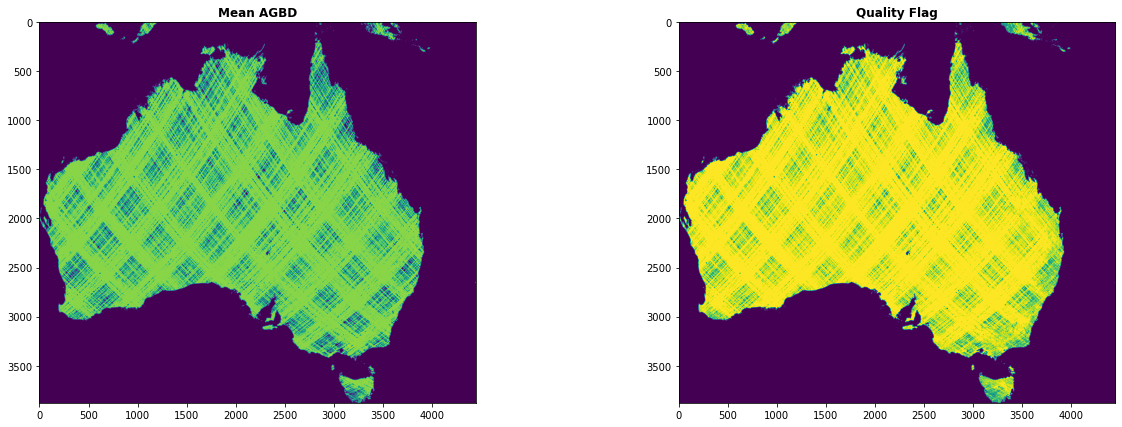

In [13]:
# read mean AGBD layer
with rio.open('2017_1.tif', 'r') as src:
    affine = src.transform
    nodata = src.nodata
    l4a_agbd = src.read(1)

# read quality flag layer
with rio.open('2017_4.tif', 'r') as src:
    nodata2 = src.nodata
    l4a_qa = src.read(1)

# plot images
fig, (ax_agbd, ax_qa) = plt.subplots(1, 2, figsize=(21, 7))
show(l4a_agbd, ax=ax_agbd, title='Mean AGBD')
show(l4a_qa, ax=ax_qa, title='Quality Flag')
plt.show()

We have AGBD values saved in the array `l4a_agbd` and quality flags saved in the array `l4a_qa`. We can use these to compute basic AGBD statistics for the states/territories of Australia.

In [14]:
# assign nodata to grids with QA value != 2 
l4a_agbd[l4a_qa!=2] = nodata
# assign nodata to grids with QA value != 1
l4a_qa[l4a_qa!=1] = nodata2

# compute grid size in hectares
grid_ha = (res_xy * res_xy) / 10000
# create a new column to store state area in hectare
aus_ease['area_ha'] = aus_ease['geometry'].area / 10000

# loop through each states
for j in aus_ease.index:
    # compute AGBD statistics for each state
    stats1 = zonal_stats(vectors=aus_ease.iloc[j].geometry, raster=l4a_agbd, affine=affine, nodata=nodata,
                                 stats=['sum', 'mean', 'count'])
    aus_ease.at[j, 'agb_total'] = stats1[0]['sum']
    aus_ease.at[j, 'count_good'] = stats1[0]['count']
    
    # compute total land count (l4a_qa == [1,2])
    stats2 = zonal_stats(vectors=aus_ease.iloc[j].geometry, raster=l4a_qa, affine=affine, nodata=nodata2,
                                 stats=['count'])
    aus_ease.at[j, 'count_land'] = stats1[0]['count'] + stats2[0]['count']

# percent grids meeting L1 requirement
aus_ease['percent_good_grids']= (aus_ease['count_good'] / aus_ease['count_land']) *100
# total AGB in Mg
aus_ease['agb_total_Mg']= aus_ease['agb_total'] * aus_ease['count_good'] * grid_ha
# Mean AGB for states
aus_ease['agbd_mean']= aus_ease['agb_total_Mg'] / aus_ease['area_ha']
# printing the statistics
aus_ease[['STE_NAME', 'area_ha', 'percent_good_grids', 'agb_total_Mg', 'agbd_mean']]

,STE_NAME,area_ha,percent_good_grids,agb_total_Mg,agbd_mean
0,New South Wales,8.007964e+07,86.664239,1.390939e+15,1.736945e+07
1,Victoria,2.276702e+07,80.792339,1.636407e+14,7.187621e+06
2,Queensland,1.729721e+08,88.878979,3.965182e+15,2.292382e+07
3,South Australia,9.844485e+07,92.635937,2.531954e+14,2.571952e+06
4,Western Australia,2.526469e+08,91.111978,2.765907e+15,1.094772e+07
5,Tasmania,6.807484e+06,65.500807,1.762664e+13,2.589303e+06
6,Northern Territory,1.348286e+08,90.008965,1.222267e+15,9.065344e+06
7,Australian Capital Territory,2.342606e+05,95.977749,2.271097e+10,9.694746e+04


In the above table, `area_ha` is the area of the state/territory in hectares; `percent_good_grids` is the percentage of the GEDI L4B grids that meets GEDI L1 mission requirement (percent standard error <20% or standard error < 20 Mg ha-1); `agb_total_Mg` is the total aboveground biomass in Mg for all grids that meets L1 mission requirement; and `agbd_mean` is mean AGBD for the state/territory in Mg ha-1.

## Getting GEDI L4B data into a GIS
Some of us may want to bring the GEDI layers into desktop Geographic Information System (GIS) clients for further analysis. Most of the modern GIS software has capabilities to support OGC web services. 
- [ESRI's ArcGIS software](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) suite also supports these capabilities - refer to [this documentation](https://pro.arcgis.com/en/pro-app/latest/help/data/services/ogc-services.htm) on how to load OGC web services into ESRI software. 
- [QGIS](https://qgis.org) is a freely available open-source desktop GIS software and supports OGC capabilities. Please refer to [this documentation](https://docs.qgis.org/3.22/en/docs/user_manual/working_with_ogc/ogc_client_support.html) for further help. 

The OGC [WMS/WCS capabilities](https://webmap.ornl.gov/ogc/dataset.jsp?ds_id=1952) are also available for the [GEDI L3 dataset](https://doi.org/10.3334/ORNLDAAC/1952), which provides gridded land surface and canopy metrics. 

